In [12]:
import os
import sys
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation

from utils.models import vae



import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go



%load_ext tensorboard
!rm -rf ../workfiles/logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
%load_ext tensorboard
!rm -rf ../workfiles/logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Generate dataset

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
retriving symbols for genes
removing 298 mithocondrial genes from the dataset
selecting genes based on median absolute deviation threshold:  5 ...
0.0
4192.1016


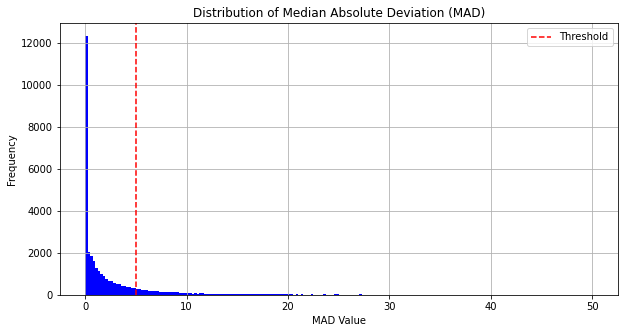

removing 28294 genes under the MAD threshold from the dataset
number of genes selected :  5977
log(1 + x) transformation...
scaling to [0, 1]...
1.0
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [3]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    feature_selection_threshold = 5, 
    retain_phases= None, 
    normalization = False,
    as_time_series = False,
    log1p=True,
    MT_removal = True, 
    min_max= True)


### Generate model

In [6]:
importlib.reload(vae) # to allow modification of the script without restarting the whole session
latent_dim = 32

vae_model = vae.generate_model(n_genes, latent_dim)
vae_model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.mean_squared_error)

#### Train Model

In [7]:
checkpoint_filepath = '../workfiles/simple_autoencoer_model/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=15, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=30)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [8]:
hist = vae_model.fit(x_train, epochs = 20, callbacks = cb) 

Epoch 1/20


2023-09-07 16:36:10.549505: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


70/70 [==============================] - 10s 117ms/step - loss: 23.1851 - reconstruction_loss: 0.0438 - kl_loss: 8.9281 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 9s 123ms/step - loss: 0.1134 - reconstruction_loss: 0.0197 - kl_loss: 0.0357 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 7s 98ms/step - loss: 0.0182 - reconstruction_loss: 0.0172 - kl_loss: 9.7808e-05 - lr: 0.0010
Epoch 4/20
70/70 [==============================] - 8s 113ms/step - loss: 0.0162 - reconstruction_loss: 0.0157 - kl_loss: 7.8253e-05 - lr: 0.0010
Epoch 5/20
70/70 [==============================] - 7s 101ms/step - loss: 0.0152 - reconstruction_loss: 0.0150 - kl_loss: 7.7537e-05 - lr: 0.0010
Epoch 6/20
70/70 [==============================] - 8s 115ms/step - loss: 0.0147 - reconstruction_loss: 0.0144 - kl_loss: 7.6753e-05 - lr: 0.0010
Epoch 7/20
70/70 [==============================] - 8s 108ms/step - loss: 0.0145 - reconstruction_loss: 0.0143 - kl_loss: 7.6021e-05 - lr: 0.0

benchmarking model : FC_vae
number of parametters of the model: 13596416
shape of the dataset: (4445, 5977)
the dataset meets the min_max requirement
loss: 0.0137181785
adding new performer to the history


,model_name,param_count,loss,obs_count,gene_number
0,FC_autoencoder,13522496,0.002833,NaN,NaN
1,FC_autoencoder,13522496,0.002833,NaN,NaN
2,FC_autoencoder,13522496,0.002833,NaN,NaN
3,FC_autoencoder,13522496,0.002826,NaN,NaN
4,FC_autoencoder,13522496,0.002810,NaN,NaN
5,FC_autoencoder,13522496,0.002810,NaN,NaN
6,FC_autoencoder,13522496,0.002810,NaN,NaN
7,FC_autoencoder,13522496,0.002810,5953.0,5953.0
8,FC_autoencoder,13522496,0.002810,2853.0,5953.0
9,FC_autoencoder,13522496,0.008133,2853.0,5953.0


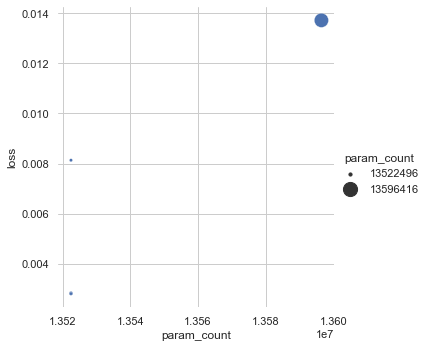

In [18]:
importlib.reload(benchmark) # to allow modification of the script without restarting the whole session
benchmark.benchmark(vae_model, x_train)

#### Monitoring training results

In [20]:
vae_model.load_weights(checkpoint_filepath)


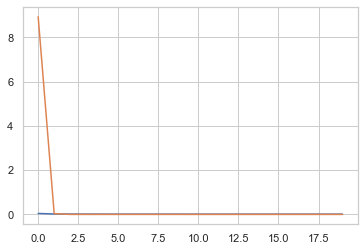

In [21]:
plt.plot(hist.history['reconstruction_loss'][0:])
plt.plot(hist.history['kl_loss'][0:])

# Visu

In [24]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_single_obs_processing(x_train, vae_model)

In [41]:
vae_model.encoder.save('../workfiles/vae_model')

INFO:tensorflow:Assets written to: ../workfiles/vae_model/assets


INFO:tensorflow:Assets written to: ../workfiles/vae_model/assets


### encoding the whole dataset

In [42]:
_, __, compressed_dataframe = vae_model.encoder.predict(x_train)


23/23 [==============================] - 0s 7ms/step


In [43]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [44]:
df.to_csv("../workfiles/processed_data_vae.csv", index=False)


# A bit of post training viz

139/139 [==============================] - 1s 4ms/step


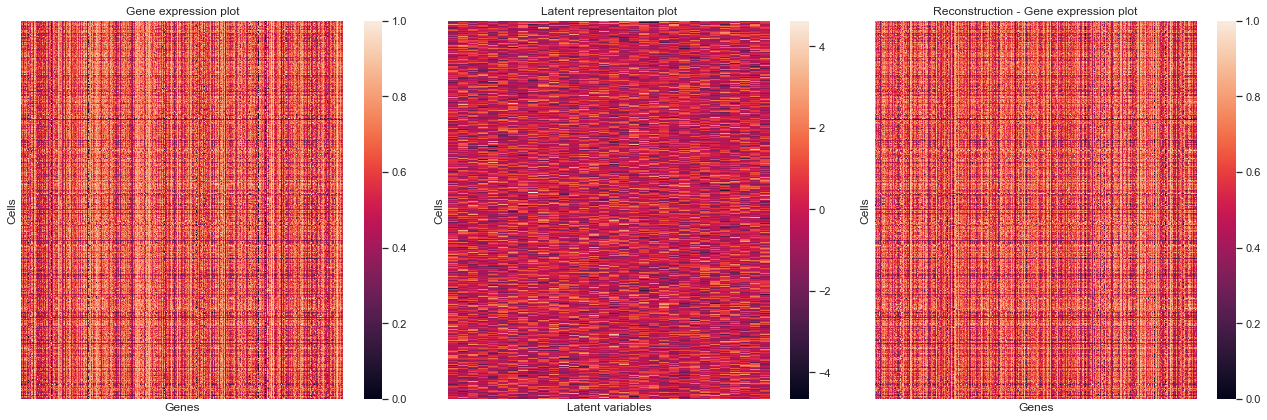

In [25]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_dataset_processing(x_train, vae_model)
